# Room Recognition with Ultra-Wide Band (UWB) Radio and Audible Sound

Group 30: LUO Wenjie, ZHENG Tianyue, ZHANG Yanbo

## Part 1: Problem Statement



In recent years, Location Based Services (LBS) has been receiving more and more attention from both academia and industrial. Among all different types of LBS based applications, room recognition remains crucial regarding its technical feasibility and extensive use cases. For example, in supermarkets, knowing the nearby stores helps achieve highly targeted advertising. In a conference center, applications offering room-level tracking help guide guests to their intended meeting rooms. In a museum, empowering visitors’ mobile phones with the capability of room-level recognition helps eliminate extra devices required for automatic exhibits explanation. Similar applications are all around the world.

To achieve room recognition, a straightforward method is camera based. By taking photos of the environment around, our smart devices can distinguish different rooms by running some sophiscated algorithms, e.g., image classification. However, camera based room recognition faces privacy issues, and the requirement on sufficient lighting and no blocking put even more constraints. Instead of using cameras, some cleverly designed wireless signal (e.g., Wi-Fi, UWB, FM) based room recognition schemes avoid the limitations without the loss of accuracy. 

To further exploit the utility of wireless signal on the application of room recognition, we want to combine the knowledge between signal processing with deep learning. More specifically, in this project, we will design a deep learning model for room recognition, leveraging the signals emitted by mobile phones. First, mobile phones will emit cell signals, wifi signals, acoustic signals and even UWB signal (in the most recent iPhone). Next, rooms’ response to the emitted signals will be recorded by the same mobile phone. In the final step, deep learning will be used to detect subtle differences in the response, perhaps in the spectrogram, and room recognition can be achieved.



By training a CNN model with our collected acoustic signal based and Ultra-Wide Band (UWB) signal based data, we can achieve pretty good result, which almost reaches the accuracy of 100%. However, we find that the conventional CNN model is much too heavy for mobile devices, especially considering such applications which demands very low computational latency. Therefore, in order to make it useful to most of the mobile devices which don't have powerful computing resource, we improve the network with the help of MobileNet. Based on the insight of MobileNet's design, we reduce the size of the network without the loss of accuracy. In this way, we achieve an accurate and light-weight deep learning based room recognition application.  




## Part 2: Data Collection and Pre-processing



This section describes how did we collect our data and make pre-processing. 

To the best of our knowledge, for our application, there is no off-the-shelf dataset that we can borrow. Therefore, we need to collect data and build our own dataset. As for pre-processing, we target on how to extract features from mass of complex value, which is the initial format to describe raw wireless signal.  

**Data collection.** To collect wireless signal based data, we need to use hardwares that can emit/receive RF or acoustic signal, which would be used to sample the wireless channel. For this project, our data comes from two different types of wireless signals, Ultra-Wide Band (UWB) signals and acoustic signals.The two types of data are collected using the devices as illustrated in Figure 1. To collect acoustic signal, we use a mobile phone to backscatter the wireless signal that locates within the audible frequency domain. To collect UWB signal, we attach a UWB radio front-end to a raspaberri pi, and by switching between the transmitting and receiving state, we can continuously sample the channel.  

For each type of the signals, we conduct experiments at 8 rooms. As shown in Figure 2, we collected data under the scenario of 5 Teaching Rooms (TR), one Office environment (OA), one big meeting room and one small meeting room. The rooms are different in terms of size, shape, and the arrangements of facilities. The different environment conditions form varying channel chracteristics, and that serves as unique signatures for different rooms. 

Figure 1: 
![](https://drive.google.com/uc?id=1SUuJMcOXI8HXW2xdgGrkU29MeDia2Q3Z)

Figure 2:
![](https://drive.google.com/uc?id=1L7q5f16VSiQwcNDAfpmyKTjmCs37dr4G)

**Dataset Pre-processing.** Generally, we have two datasets, one is the acoustic signal based dataset,and another one is UWB signal based dataset. Initially, both of the dataset is formed by mass of complex numbers, which describes the variation of the wireless signals across time and frequency. To explore the characteristic and extract the features from the meaningless complex numbers, we applied conventional signal processing methods to the raw data. 

More specifically, if we plot the amplitude of the received wireless signal over time, what we get looks in a way similar to the illustration in Figure 3. For a certain location of the transmitter, there will be a strong reflected signal appearing in a periodic manner. To highlight this pattern, we segmented the time series according to the observed period, and then overlapping the segmentation in a vertical direction, which produces a region with higher power than the adjacent area. For UWB signal, we applied FFT to the obtained trace, and derived a spatial spectrum, as shown in the left of Figure 4. For acoustic signal, we use similar method to obtain the grid heat map, which shows the power distribution around the space, as shown in the right of Figure 4. 

Figure 3:
![](https://drive.google.com/uc?id=1faHbc7E0_y3iA1aC3JXpPZn3y_gjnOQv)
Figure 4:
![](https://drive.google.com/uc?id=1ZA9tek4FzJ95LcmR1VGdvFKYr6071OIv)






## Part 3: Data Exploration

After data collection and pre-processing, we can now make further exploration on the dataset. In this section, we visualize the pre-processed data for both of the two signal types. 

### Initial setup

In this part, we link to our google drive to load the dataset. After that, we import some pytorch libraries to do the visualization, and we set seed to make sure the consistency over tests. 

In [6]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_name = 'Lightweight_Room_Recognition_using_UWB_Radio_and_Audible_Sound.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
./Lightweight_Room_Recognition_using_UWB_Radio_and_Audible_Sound.ipynb

/content/gdrive/My Drive/CE7454_group_project


In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import utils
import time
import numpy as np
import scipy.io as sio
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from complexLayers import ComplexBatchNorm2d, ComplexConv2d, ComplexLinear, ComplexMaxPool2d
from complexFunctions import complex_relu, complex_max_pool2d
from os.path import dirname, join as pjoin
from random import randint

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device= torch.device("cuda")


random_seed = 5

### Load acoustic data

Here we load the acoustic signal based dataset, which is the version after pre-processing. 

In [0]:
audible_data_path = './audible_data_noise'
# read csv files contains spectrogram for each room
files = os.listdir(audible_data_path)
# get the class labels
classes = ['Room '+ item[:-4] for item in files]
idx = 0
audible_data = np.array([], dtype=np.int64).reshape(0,141)
# read file
# raw_data = pd.read_csv(file)
# label = np.zeros(raw_data.shape[0]) + 1
# label = label.reshape(raw_data.shape[0],1)
# new_data = np.append(raw_data, label, axis=1)

for file in files:
  raw_data = pd.read_csv(os.path.join(audible_data_path,file)).to_numpy()
  label = np.zeros(raw_data.shape[0]) + idx
  label = label.reshape(raw_data.shape[0],1)
  new_data = np.append(raw_data, label, axis=1)
  
  audible_data = np.append(audible_data,new_data,axis=0)
  idx += 1

### Load UWB data

Here we load th UWB signal based dataset, which is the version after pre-processing. 

In [0]:
def read_uwb_dataset(path):
    dataset_contents = sio.loadmat(dataset_name) 

    dataset_contents_r = dataset_contents['sfr']

    dataset_contents_r = np.swapaxes(dataset_contents_r, 0, 2)
    dataset_contents_r = dataset_contents_r[:, :, ::4]

    dataset_contents_i = dataset_contents['sfi']
    dataset_contents_i = np.swapaxes(dataset_contents_i, 0, 2)
    dataset_contents_i = dataset_contents_i[:, :, ::4]
    
    dataset_contents_r_d = dataset_contents['sfreqr']
    dataset_contents_r_d = np.swapaxes(dataset_contents_r_d, 0, 2)
    dataset_contents_r_d = dataset_contents_r_d[:, :, ::4]

    dataset_contents_i_d = dataset_contents['sfreqi']
    dataset_contents_i_d = np.swapaxes(dataset_contents_i_d, 0, 2)
    dataset_contents_i_d = dataset_contents_i_d[:, :, ::4]
    
    label_contents = dataset_contents['labelsm']
    
    return dataset_contents_r, dataset_contents_i, dataset_contents_r_d, dataset_contents_i_d, label_contents

In [0]:
uwb_data_dir = "./uwb_data"
dataset_name = pjoin(uwb_data_dir, 'dataset.mat')
dataset_contents_r, dataset_contents_i, dataset_contents_r_d, dataset_contents_i_d, labels_contents = read_uwb_dataset(uwb_data_dir)

### Visualize the UWB based dataset and the acoustic signal based dataset 



In this part, we visualize the two types of dataset based on our pre-processed results. 

In [0]:
fig, ax = plt.subplots(2,3)
# fig.suptitle("UWB Radio and Audible Sound Spectrogram of different rooms")
fig.set_size_inches(10.5, 6.5)
ax[0,0].imshow(dataset_contents_r[5, :50, :].T)
ax[0,0].set_title('Room L3')
ax[0,1].imshow(dataset_contents_r[489, :50, :].T)
ax[0,1].set_title('Room L4')
ax[0,2].imshow(dataset_contents_r[1485, :50, :].T)
ax[0,2].set_title('Room TR1')

ax[1,0].imshow(audible_data[0][:140].reshape(10,14))
ax[1,0].set_title(classes[0])
ax[1,1].imshow(audible_data[1000][:140].reshape(10,14))
ax[1,1].set_title(classes[1])
ax[1,2].imshow(audible_data[2000][:140].reshape(10,14))
ax[1,2].set_title(classes[2])
plt.show()


Figure 5:

![](https://drive.google.com/uc?id=1EO6syYBBkUOQ7OX5j0_nsSGc64gD4h-K)

### Observation 
The visualized result is shown in Figure 5. In this figure, we show the spatial spectrum and the grid heat map of the UWB signal based dataset and the acoustic signal based dataset, respectively. For each type, we plot the result for three different rooms. 

The three figures in the upper row are the three plots of the spatial spectrum for UWB signal based dataset. As we can see, at the region of left side, the power is always higher, which corresponding with the dominant path comes from a specific direction. Even though the location of the power concentrate region is similar, the power distribution at the other area is not the same, which can be used to distinguish different rooms. 

The three figures in the bottom row are the plots related to the grid heat map of acoustic signals. When compared with the UWB signal based dataset, we can see the result is actually much more confusing and inconsistent. The reason behind is that, for acoustic signals, the bandwidth is just several MHz, while the bandwidth of UWB signal can reach hundreds of MHz. The great different on the bandwidth decides the resolution. Therefore, it seems much more difficult to predict with the acoustic signal. 

Overall, based on the spatial spectrum of the UWB signal based dataset and the acoustic signal based dataset, there is more or less difference among different rooms, which implies the different rooms' response to the UWB and audible sound. As we can see, the responses have different time-frequency characteristics. Therefore, it is possible to develop a neural network to distinguish different rooms

## Part 4: Data analysis with Deep Learning

### Using Audible Sound for Room recognition

#### Load Audible data set and split into training and test data set

In [0]:
audible_data_path = './audible_data_noise'

classes = os.listdir(audible_data_path)
idx = 0
audible_data = np.array([], dtype=np.int64).reshape(0,141)

for file in classes:
  raw_data = pd.read_csv(os.path.join(audible_data_path,file)).to_numpy()
  label = np.zeros(raw_data.shape[0]) + idx
  label = label.reshape(raw_data.shape[0],1)
  new_data = np.append(raw_data, label, axis=1)
  
  audible_data = np.append(audible_data,new_data,axis=0)
  idx += 1

# split data
audible_data = shuffle(audible_data)
train,test = train_test_split(audible_data, test_size=0.2)
train_num = train.shape[0]
test_num = test.shape[0]

# train data
train_data = train[:,:-1]
# convert to 2D
train_data = train_data.reshape(train_num,10,14,order = 'F')
# convert to torch tensor float()
train_data = torch.tensor(train_data).float()
# label need to be in data type long()
train_label = torch.tensor(train[:,-1:]).long()
train_label = train_label.view(train_num)
# test data
test_data = test[:,:-1]
# scale data
# test_data = scaler.fit_transform(test_data)
test_data = test_data.reshape(test_num,10,14,order = 'F')
test_data = torch.tensor(test_data).float()
# label need to be in data type long()
test_label = torch.tensor(test[:,-1:]).long()
test_label = test_label.view(test_num)

#### Construct conventional CNN

In [0]:
class Audible_ConvNN(nn.Module):

    def __init__(self):

        super(Audible_ConvNN, self).__init__()

        # CL1:   1 x 10 x 14  -->    16 x 10 x 14 
        self.conv1 = nn.Conv2d(1,   16,  kernel_size=3,  padding=1 )
        
        self.batchnorm1 = nn.BatchNorm2d(16)
        # MP1: 16 x 10 x 14 -->    16 x 5 x 7
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   16 x 5 x 7    32 x 5 x 7 
        self.conv2 = nn.Conv2d(16,  32,  kernel_size=3,  padding=1 )
        
        self.batchnorm2 = nn.BatchNorm2d(32)
        # MP2: 32 x 5 x 7 -->    32 x 1 x 6
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.linear = nn.Linear(192, 8)



    def forward(self, x):

      
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        
       
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = x.view(-1, 192)
        x = self.linear(x)

    
        return x

#### Count parameters in Conventional CNN: 6440 parameters

In [0]:
net = Audible_ConvNN()
utils.display_num_param(net)

net = net.to(device)

There are 6440 (0.01 million) parameters in this neural network


In [0]:
criterion = nn.CrossEntropyLoss()

my_lr=0.25 

bs= 128

In [0]:
def eval_on_audible_test_set():

    running_error=0
    num_batches=0

    for i in range(0,test_num,bs):

        minibatch_data =  test_data[i:i+bs].unsqueeze(dim=1)
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # inputs = (minibatch_data - mean)/std    # ONLY CHANGE IS HERE!
        inputs = minibatch_data
        scores=net( inputs ) 

        error = utils.get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

#### Evaluation on Conventional CNN

In [0]:
start=time.time()

for epoch in range(1,10):
    
    if not epoch%5:
        my_lr = my_lr / 1.5
        
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(train_num)
 
    for count in range(0,train_num,bs):
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices].unsqueeze(dim=1)
        minibatch_label=  train_label[indices]
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # inputs = (minibatch_data - mean)/std      # ONLY CHANGE IS HERE!
        inputs = minibatch_data
        
        inputs.requires_grad_()

        scores=net( inputs ) 

        loss =  criterion( scores , minibatch_label) 
          
        loss.backward()
        
        optimizer.step()
        

        # COMPUTE STATS
        
        running_loss += loss.detach().item()
        
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_audible_test_set() 
    print(' ')
   

#### Model Performance Evaluation

In [0]:
def show_prob_room(p,num_class):

    p=p.data.squeeze().numpy()

    ft=15
    label = num_class
    #p=p.data.squeeze().numpy()
    y_pos = np.arange(len(p))*1.2
    target=2
    width=0.9
    col= 'blue'
    #col='darkgreen'

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # the plot
    ax.barh(y_pos, p, width , align='center', color=col)

    ax.set_xlim([0, 1.3])
    #ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

    # y label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label, fontsize=ft)
    ax.invert_yaxis()  
    #ax.set_xlabel('Performance')
    #ax.set_title('How fast do you want to go today?')

    # x label
    ax.set_xticklabels([])
    ax.set_xticks([])
    #x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
    #ax.set_xticks(x_pos)
    #ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(4)


    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax.transData, color= col,fontsize=ft)



    plt.show()

In [0]:
# choose a picture at random
idx=randint(0, test_num-1)
im=test_data[idx]
im = im.view(10,14)
# diplay the picture
im = im.cpu()
plt.title(classes[test_label[idx]])
utils.show(im)


# send to device, rescale, and view as a batch of 1 
im = im.to(device)
# im= (im-mean) / std
im=im.view(1,10,14).unsqueeze(dim=1)

# feed it to the net and display the confidence scores
scores =  net(im) 
probs= F.softmax(scores, dim=1)
show_prob_room(probs.cpu(),classes)
print(test_label[idx])

In [0]:
new_test_data = test_data.unsqueeze(dim=1)
new_test_label = test_label
new_test_data = new_test_data.cuda()
# test_data= (test_data-mean) / std
scores = net( new_test_data )
out = F.softmax(scores)
preds = torch.argmax(out,dim=1)

# load to cpu
preds = preds.cpu()
print(confusion_matrix(new_test_label,preds))
print("\n")
print(classification_report(new_test_label,preds))

In [0]:
confusion_mat = confusion_matrix(new_test_label,preds)
# confusion_mat = torch.tensor(confusion_mat)

df_cm = pd.DataFrame(confusion_mat, index = [i for i in classes],
              columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

#### Construct Depthwise separable Mobile Net
**MobileNet** is an efficient model for mobile and embedded vision application. 
MobileNet is based on a streamlined architechture that uses **depthwise separable convolutions (DSC)** to build light weight deep neural network.
Depthwise Separable Convolution is a form of factorized convolution that factorize a standard convolution into a depthwise convolution and a 1x1 conlution called pointwise convolution.
A standard convolution both filters and combines inputs into a new set of outputs in one step. the DSC splits this into depthwise convolution and pointwise convolution (as demonstrates in figure 1):
1. depthwise convolutions first apply filter to each input channel.
2. pointwise convolution applies 1x1 convolution to create a linear combination of the output of the depthwise layer.

By expressing standard convolution as a two step process of filtering and combining, the reduction in computation is of: (1/N + 1/DxD, where N is output channel, D is kernel size). Therefore, when we use a 3x3 kernel in DSC, we will get 8 to 9 times less computation than standard convolution.

![figure 1](https://www.pyimagesearch.com/wp-content/uploads/2017/09/mobilenet_depthwise.png)

In [0]:
class Audible_MobileNet(nn.Module):
    def __init__(self):
        super(Audible_MobileNet, self).__init__()

        # normal Conv
        def conv_bn(inp, oup):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride=1, padding=1, dilation=2),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )
        # depth wise separable conv
        def conv_dw(inp, oup):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride=1, padding=1, groups=inp, dilation=2),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, stride=1, dilation=2),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )
        self.conv_bn1 = conv_bn(1,16)
        # self.pool1 = nn.AvgPool2d(2,2)
        self.conv_dw1 = conv_dw(16,32)
        self.pool2 = nn.AvgPool2d(2,2)
        self.linear = nn.Linear(480,8)
        # self.linear2 = nn.Linear(1024,8)

    def forward(self, x):
        x = self.conv_bn1(x)
        # print(x.shape)
        # x = self.pool1(x)
        # print(x.shape)
        x = self.conv_dw1(x)
        # print(x.shape)
        x = self.pool2(x)
        # print(x.shape)
        x = x.view(-1, 480)
        x = self.linear(x)
        # x = F.relu(x)
        # # LL2:   1024  -->  8 
        # x = self.linear2(x)
        
        return x

#### Count the parameter on Mobile Net: 4840 (25% reduction)

In [0]:
net = Audible_MobileNet()
utils.display_num_param(net)

net = net.to(device)

There are 4840 (0.00 million) parameters in this neural network


#### Evaluation on Mobile Net with Audible data

In [0]:
start=time.time()

for epoch in range(1,10):
    
    if not epoch%5:
        my_lr = my_lr / 1.5
        
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(train_num)
 
    for count in range(0,train_num,bs):
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices].unsqueeze(dim=1)
        minibatch_label=  train_label[indices]
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # inputs = (minibatch_data - mean)/std      # ONLY CHANGE IS HERE!
        inputs = minibatch_data
        
        inputs.requires_grad_()

        scores=net( inputs ) 

        loss =  criterion( scores , minibatch_label) 
          
        loss.backward()
        
        optimizer.step()
        

        # COMPUTE STATS
        
        running_loss += loss.detach().item()
        
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_audible_test_set() 
    print(' ')

epoch= 1 	 time= 0.0053400397300720215 min 	 lr= 0.16666666666666666 	 loss= 0.5226507170498371 	 error= 11.709452509880066 percent
error rate on test set = 4.815323077715361 percent
 
epoch= 2 	 time= 0.010588582356770833 min 	 lr= 0.16666666666666666 	 loss= 0.18290817342698573 	 error= 5.021048665046692 percent
error rate on test set = 4.334553846946129 percent
 
epoch= 3 	 time= 0.01573590040206909 min 	 lr= 0.16666666666666666 	 loss= 0.15693263351917267 	 error= 4.899664282798767 percent
error rate on test set = 4.516750115614672 percent
 
epoch= 4 	 time= 0.0209118644396464 min 	 lr= 0.16666666666666666 	 loss= 0.14580892354249955 	 error= 4.737990736961365 percent
error rate on test set = 4.636942423306978 percent
 
epoch= 5 	 time= 0.026109162966410318 min 	 lr= 0.1111111111111111 	 loss= 0.13579608887434005 	 error= 4.786673665046692 percent
error rate on test set = 4.697038577153132 percent
 
epoch= 6 	 time= 0.03127458095550537 min 	 lr= 0.1111111111111111 	 loss= 0.1330556

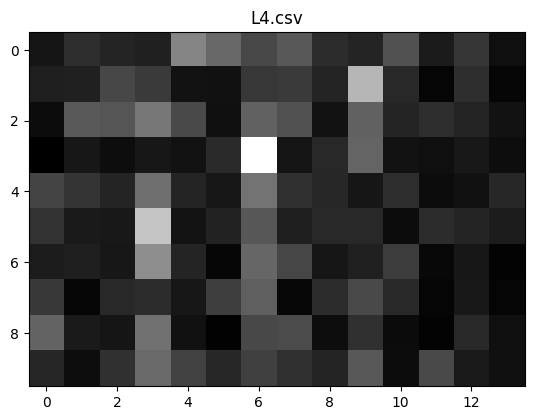

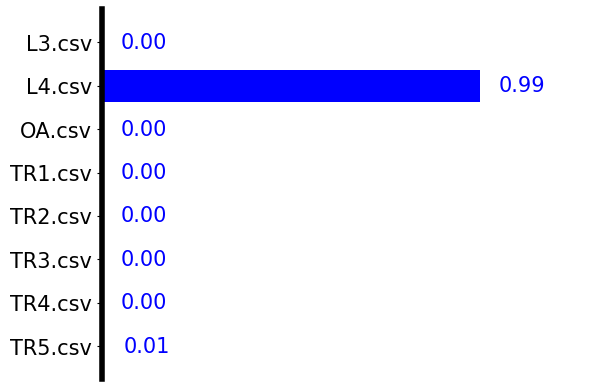

tensor(1)


In [0]:
# choose a picture at random
idx=randint(0, test_num-1)
im=test_data[idx]
im = im.view(10,14)
# diplay the picture
im = im.cpu()
plt.title(classes[test_label[idx]])
utils.show(im)


# send to device, rescale, and view as a batch of 1 
im = im.to(device)
# im= (im-mean) / std
im=im.view(1,10,14).unsqueeze(dim=1)

# feed it to the net and display the confidence scores
scores =  net(im) 
probs= F.softmax(scores, dim=1)
show_prob_room(probs.cpu(),classes)
print(test_label[idx])

In [0]:
new_test_data = test_data.unsqueeze(dim=1)
new_test_label = test_label
new_test_data = new_test_data.cuda()
# test_data= (test_data-mean) / std
scores = net( new_test_data )
out = F.softmax(scores)
preds = torch.argmax(out,dim=1)

# load to cpu
preds = preds.cpu()
print(confusion_matrix(new_test_label,preds))
print("\n")
print(classification_report(new_test_label,preds))

[[198   2   0   2   0   0   3   0]
 [  2 214   1   1   0   0   2   0]
 [  2   2 184   4   2   1   2   1]
 [  2   1   1 194   0   0   1   0]
 [  1   3   0   1 181   0   1   0]
 [  1   4   0   4   1 196   1   0]
 [  3   3   0   5   3   0 175   0]
 [  2   1   0   3   0   0   3 185]]


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       205
           1       0.93      0.97      0.95       220
           2       0.99      0.93      0.96       198
           3       0.91      0.97      0.94       199
           4       0.97      0.97      0.97       187
           5       0.99      0.95      0.97       207
           6       0.93      0.93      0.93       189
           7       0.99      0.95      0.97       194

    accuracy                           0.95      1599
   macro avg       0.96      0.95      0.96      1599
weighted avg       0.96      0.95      0.96      1599



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


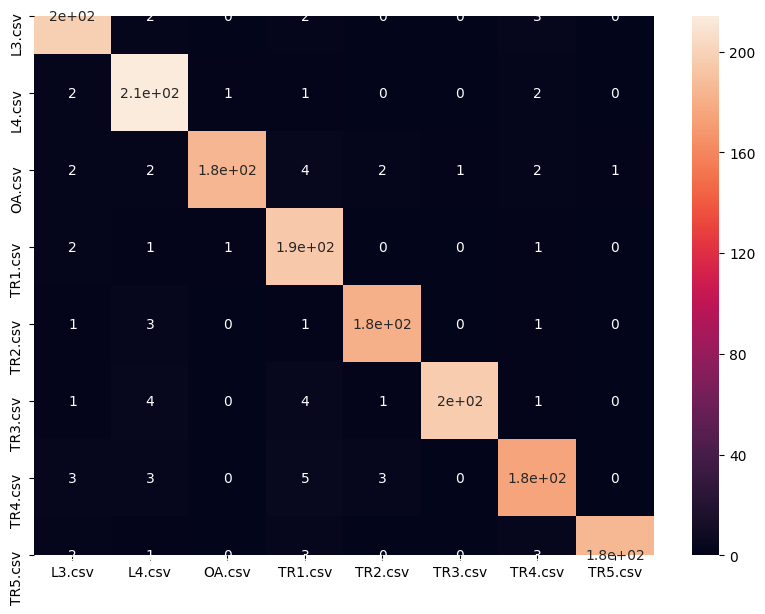

In [0]:
confusion_mat = confusion_matrix(new_test_label,preds)
# confusion_mat = torch.tensor(confusion_mat)

df_cm = pd.DataFrame(confusion_mat, index = [i for i in classes],
              columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

### Using UWB data for Room recognition

#### Load UWB data and split into training and testing dataset

The trasmitted signal is modulated using IQ modulation. The term “IQ” is an abbreviation for “in-phase” and “quadrature.” In electrical engineering, a sinusoid with angle modulation can be decomposed into, or synthesized from, two amplitude-modulated sinusoids that are offset in phase by one-quarter cycle (π/2 radians). All three functions have the same frequency. The amplitude modulated sinusoids are known as in-phase and quadrature components. The radar signal obtained from the radar contains the demodulated in-phase and quadrature signals. Next we read the data.

In [0]:
dataset_name = pjoin(uwb_data_dir, 'dataset.mat')

dataset_contents_r, dataset_contents_i, dataset_contents_r_d, dataset_contents_i_d, labels_contents = read_uwb_dataset(dataset_name)

train_percentage = 0.7

indices = np.random.RandomState(seed=random_seed).permutation(dataset_contents_r.shape[0])
train_size = round(dataset_contents_r.shape[0]*train_percentage)
test_size = dataset_contents_r.shape[0]-train_size
train_idx, test_idx = indices[:train_size], indices[train_size:]

train_data_r_, test_data_r_ = dataset_contents_r[train_idx, :], dataset_contents_r[test_idx, :]
train_data_i_, test_data_i_ = dataset_contents_i[train_idx, :], dataset_contents_i[test_idx, :]

train_data_r_d_, test_data_r_d_ = dataset_contents_r_d[train_idx, :], dataset_contents_r_d[test_idx, :]
train_data_i_d_, test_data_i_d_ = dataset_contents_i_d[train_idx, :], dataset_contents_i_d[test_idx, :]

train_label_, test_label_ = labels_contents[:, train_idx], labels_contents[:, test_idx]

In [0]:
train_data_r = torch.from_numpy(train_data_r_)
test_data_r = torch.from_numpy(test_data_r_)

train_data_i = torch.from_numpy(train_data_i_)
test_data_i = torch.from_numpy(test_data_i_)

train_label = torch.from_numpy(train_label_)
test_label = torch.from_numpy(test_label_)

In [0]:
meanr = train_data_r.mean()
stdr = train_data_r.std()

meani = train_data_i.mean()
stdi = train_data_i.std()

#### Construct Conventional CNN

In [0]:
criterion = nn.CrossEntropyLoss()
my_lr=0.005
num_of_classes = 8
bs= 10


In [0]:
mystic_num = 13200

class UWB_ConvNN(nn.Module):

    def __init__(self):
       
        super(UWB_ConvNN, self).__init__()
        self.conv1 = ComplexConv2d(1, 50, 5, padding = 1)
        self.bn1  = ComplexBatchNorm2d(50)
        self.pool1 = ComplexMaxPool2d(2, 2)
        
        self.conv2 = ComplexConv2d(50, 100, 5, padding = 1)
        self.bn2 = ComplexBatchNorm2d(100)
        self.pool2 = ComplexMaxPool2d(2, 2)
        
        self.linear1 = ComplexLinear(mystic_num, num_of_classes)

    def modular_forward(self, x):
        
        xr = x[0].float()
        xi = x[1].float()  #torch.zeros(xr.shape, dtype = xr.dtype, device = xr.device)

        # CL1:   4000 x 30  -->    50 x 28 x 28 
        xr, xi = self.conv1(xr, xi)
        xr, xi = complex_relu(xr, xi)
        xr, xi = self.bn1(xr, xi)
        
        # MP1: 50 x 4000 x 30 -->    50 x 14 x 14
        xr, xi = self.pool1(xr, xi)
        
        # CL2:   50 x 2000 x 15  -->    100 x 2000 x 15
        xr, xi = self.conv2(xr, xi)
        xr, xi = complex_relu(xr, xi)
        xr, xi = self.bn2(xr, xi)
        
        # MP2: 100 x 2000 x 15 -->    100 x 1000 x 7
        xr, xi = self.pool2(xr, xi)
        
        # LL1:   100 x 1000 x 7 = 4900  -->  100 
        xr = xr.view(-1, mystic_num)
        xi = xi.view(-1, mystic_num)
        xr, xi = self.linear1(xr, xi)

        xr, xi = complex_relu(xr, xi)

        x = torch.sqrt(torch.pow(xr,2)+torch.pow(xi,2))
        return x
    
    def forward(self, x):
        
        x = self.modular_forward(x)
        
        return F.softmax(x, dim=1)
       # return x

#### Count the parameter number on Conventional Neural Network: 0.46 million

In [0]:
net=UWB_ConvNN()

net = net.to(device)

print(net)
utils.display_num_param(net)

meanr=meanr.to(device)
stdr=stdr.to(device)

meani=meani.to(device)
stdi=stdi.to(device)

UWB_ConvNN(
  (conv1): ComplexConv2d(
    (conv_r): Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (conv_i): Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  )
  (bn1): ComplexBatchNorm2d()
  (pool1): ComplexMaxPool2d()
  (conv2): ComplexConv2d(
    (conv_r): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (conv_i): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  )
  (bn2): ComplexBatchNorm2d()
  (pool2): ComplexMaxPool2d()
  (linear1): ComplexLinear(
    (fc_r): Linear(in_features=13200, out_features=8, bias=True)
    (fc_i): Linear(in_features=13200, out_features=8, bias=True)
  )
)
There are 464766 (0.46 million) parameters in this neural network


In [0]:
def eval_on_uwb_test_set():
    

    running_error=0
    num_batches=0
    
    score_arr= []
    elapsed_sum = 0
    cnt = 0        
    for i in range(0,test_size,bs):
        
        inference_start = time.time()
        minibatch_data_r =  test_data_r[i:i+bs].unsqueeze(dim=1)
        minibatch_data_i =  test_data_i[i:i+bs].unsqueeze(dim=1)
        minibatch_label= test_label[:, i:i+bs]

        minibatch_data_r=minibatch_data_r.to(device)
        minibatch_data_i=minibatch_data_i.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputsr = (minibatch_data_r - meanr)/stdr   # ONLY CHANGE IS HERE!
        inputsi = (minibatch_data_i - meani)/stdi   # ONLY CHANGE IS HERE!

        scores=net([inputsr, inputsi]) 
        
        scores_np = scores.data.cpu().numpy()
        scores_np = np.argmax(scores_np, axis=1, out=None)
        score_arr.extend(scores_np.tolist())
        

        error = utils.get_error( scores , minibatch_label.long())

        running_error += error.item()

        num_batches+=1
        cnt = cnt+1
        
        elapsed_sum = elapsed_sum+time.time()-inference_start
    # AVERAGE STATS THEN DISPLAY
    print("Average Elapsed Time for One Inference")
    print(elapsed_sum/cnt)
    
    test_label_arr = test_label.tolist()
    
    conf_mat= confusion_matrix(score_arr, test_label_arr[0])
    print(classification_report(score_arr, test_label_arr[0]))
    
    df_cm = pd.DataFrame(conf_mat, index = [i for i in "ABCDEFGH"],
                  columns = [i for i in "ABCDEFGH"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

#### Evaluation on Conventional CNN with UWB data

The Model is able to achieve ~90% accuracy

epoch= 1 	 time= 6.503477334976196 s 	 lr= 0.005 	 loss= 2.053802557821785 	 error= 78.45982116247926 percent
Average Elapsed Time for One Inference
0.0102013498544693
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.42      0.59       279
           3       1.00      0.18      0.30       680
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.25       959
   macro avg       0.25      0.08      0.11       959
weighted avg       1.00      0.25      0.39       959



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


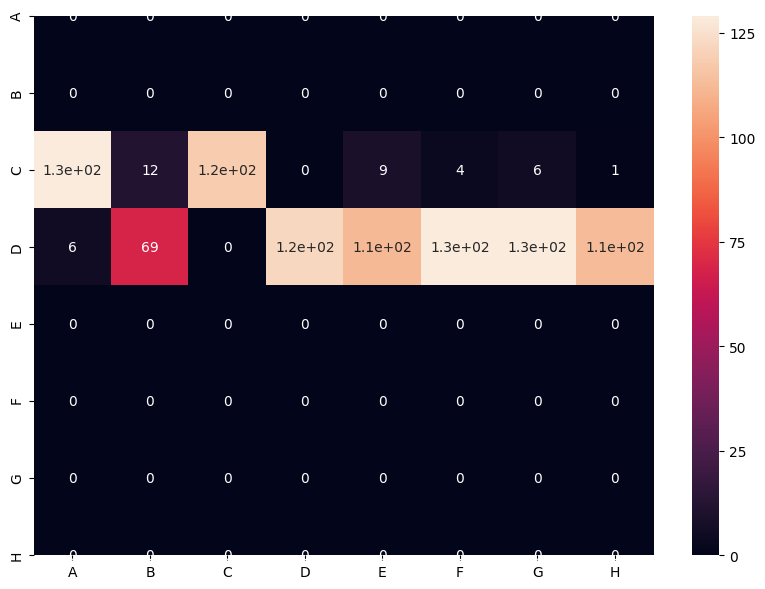

error rate on test set = 74.96527762462696 percent
 
epoch= 2 	 time= 14.286083936691284 s 	 lr= 0.005 	 loss= 2.0113543421030045 	 error= 75.21205352885383 percent
Average Elapsed Time for One Inference
0.009991000096003214
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.14      0.25       837
           3       1.00      1.00      1.00       122
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.25       959
   macro avg       0.25      0.14      0.16       959
weighted avg       1.00      0.25      0.34       959



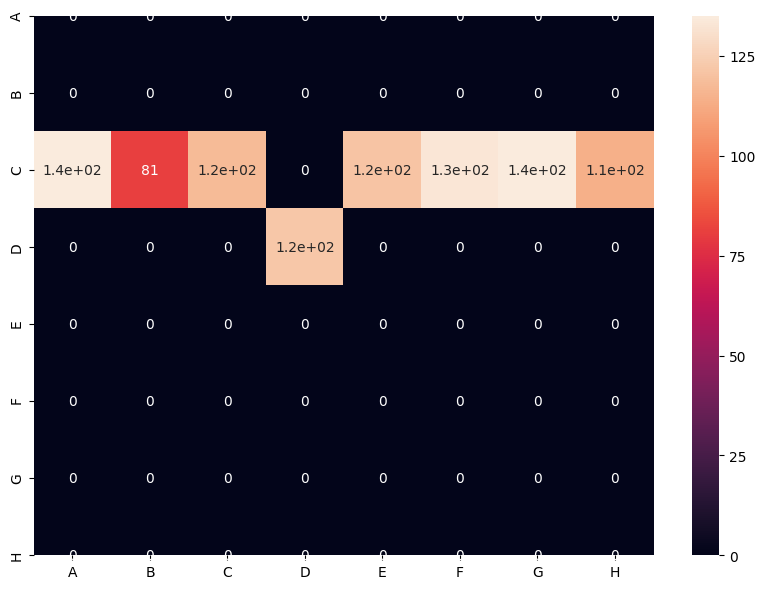

error rate on test set = 74.96527762462696 percent
 
epoch= 3 	 time= 22.15928888320923 s 	 lr= 0.005 	 loss= 1.9947851678090436 	 error= 73.03571418992111 percent
Average Elapsed Time for One Inference
0.010091332097848257
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00       118
           3       1.00      0.15      0.25       841
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.25       959
   macro avg       0.25      0.14      0.16       959
weighted avg       1.00      0.25      0.35       959



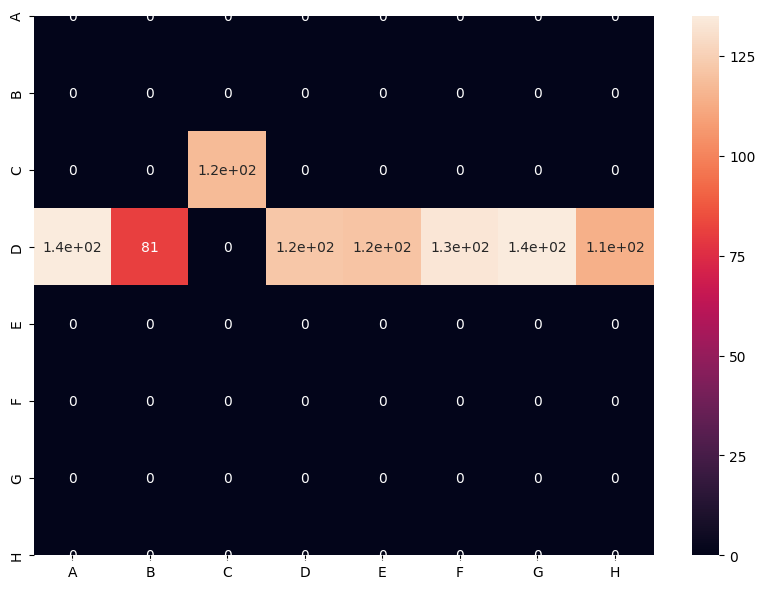

error rate on test set = 74.96527762462696 percent
 
epoch= 4 	 time= 29.979276180267334 s 	 lr= 0.005 	 loss= 1.7327073514461517 	 error= 50.12276760701623 percent
Average Elapsed Time for One Inference
0.01014383633931478
              precision    recall  f1-score   support

           0       0.96      0.35      0.51       367
           1       1.00      0.96      0.98        84
           2       1.00      1.00      1.00       118
           3       1.00      0.95      0.97       129
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         3
           6       1.00      0.98      0.99       138
           7       1.00      0.98      0.99       116

    accuracy                           0.73       959
   macro avg       0.74      0.65      0.68       959
weighted avg       0.98      0.73      0.80       959



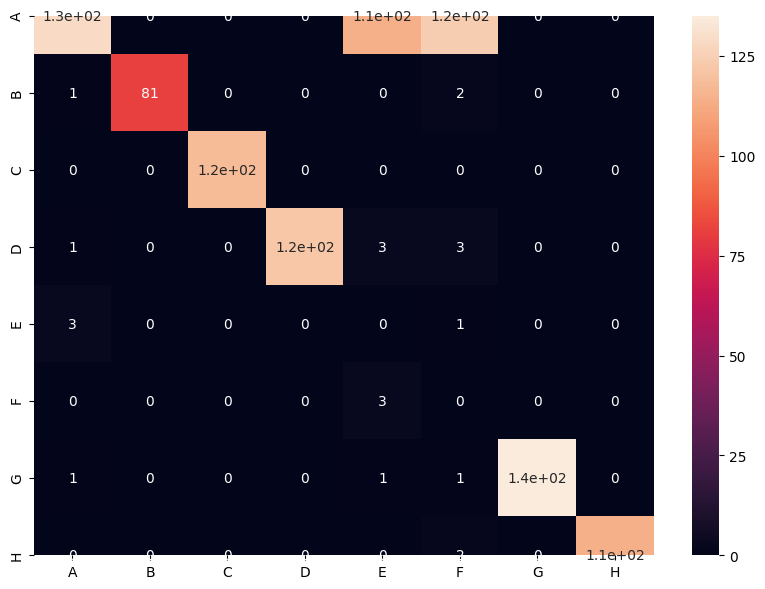

error rate on test set = 40.55555512507756 percent
 
epoch= 5 	 time= 37.79745936393738 s 	 lr= 0.0033333333333333335 	 loss= 1.5925627941531795 	 error= 39.486606871443136 percent
Average Elapsed Time for One Inference
0.009990411500136057
              precision    recall  f1-score   support

           0       0.99      0.36      0.52       372
           1       1.00      0.98      0.99        83
           2       1.00      1.00      1.00       118
           3       1.00      0.95      0.98       128
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           6       1.00      0.99      0.99       137
           7       1.00      0.97      0.99       117

    accuracy                           0.73       959
   macro avg       0.75      0.66      0.68       959
weighted avg       0.99      0.73      0.80       959



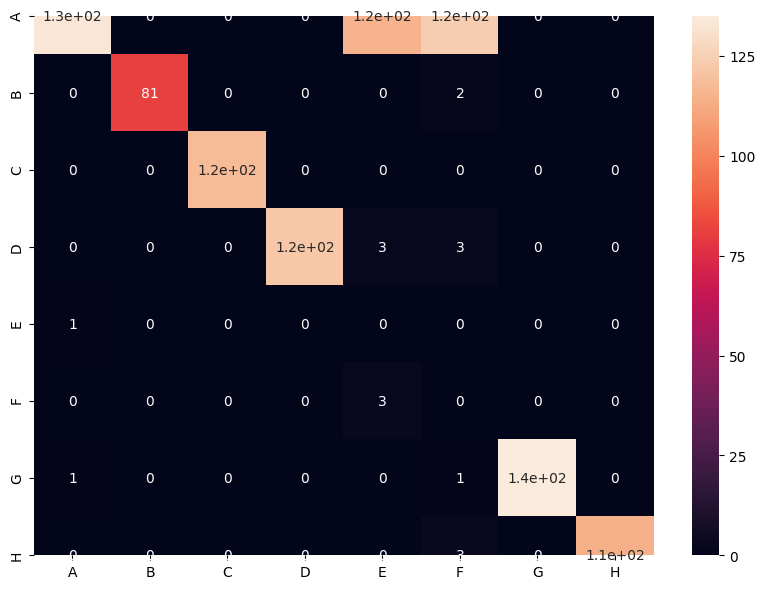

error rate on test set = 40.55555512507756 percent
 
epoch= 6 	 time= 45.58091139793396 s 	 lr= 0.0033333333333333335 	 loss= 1.539024753762143 	 error= 32.48883863644941 percent
Average Elapsed Time for One Inference
0.010227881371974945
              precision    recall  f1-score   support

           0       0.97      0.56      0.71       235
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00       118
           3       1.00      0.97      0.98       126
           4       0.00      0.00      0.00         0
           5       1.00      0.90      0.95       147
           6       1.00      0.98      0.99       138
           7       1.00      1.00      1.00       114

    accuracy                           0.87       959
   macro avg       0.87      0.80      0.83       959
weighted avg       0.99      0.87      0.92       959



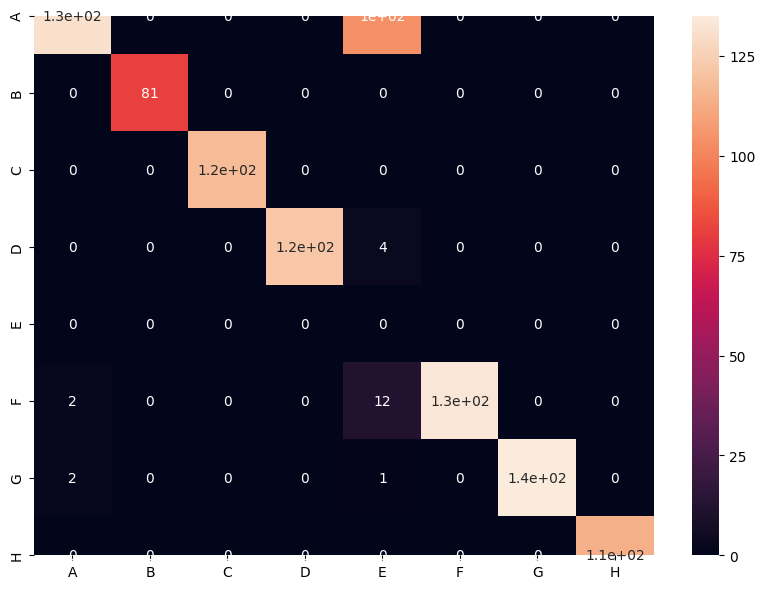

error rate on test set = 26.67823980251948 percent
 
epoch= 7 	 time= 53.57925796508789 s 	 lr= 0.0033333333333333335 	 loss= 1.4940540359488554 	 error= 27.28794560368572 percent
Average Elapsed Time for One Inference
0.010163707037766775
              precision    recall  f1-score   support

           0       0.96      0.54      0.69       240
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00       118
           3       1.00      0.98      0.99       125
           4       0.00      0.00      0.00         0
           5       1.00      0.92      0.96       145
           6       1.00      0.99      1.00       136
           7       1.00      1.00      1.00       114

    accuracy                           0.87       959
   macro avg       0.87      0.80      0.83       959
weighted avg       0.99      0.87      0.91       959



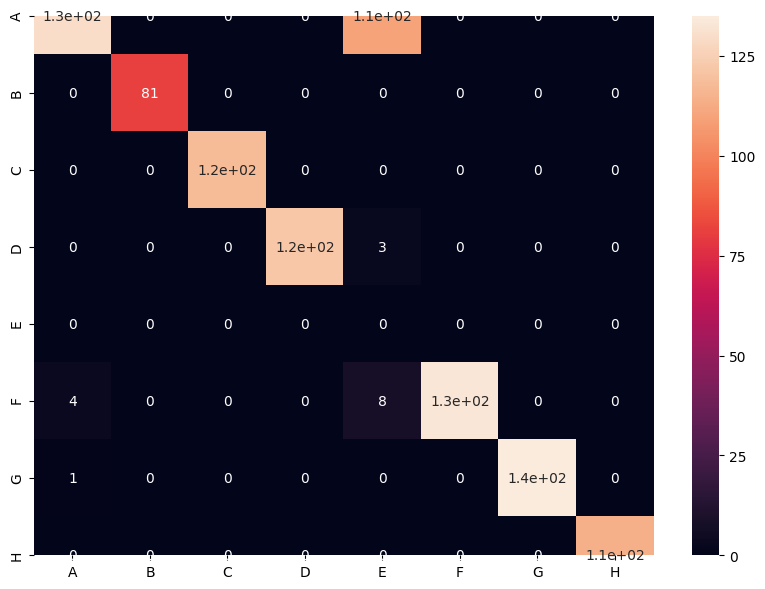

error rate on test set = 26.67823980251948 percent
 
epoch= 8 	 time= 61.388258934020996 s 	 lr= 0.0033333333333333335 	 loss= 1.494165408291987 	 error= 27.321427688002586 percent
Average Elapsed Time for One Inference
0.009980946779251099
              precision    recall  f1-score   support

           0       0.96      0.54      0.69       242
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00       118
           3       1.00      0.98      0.99       125
           4       0.00      0.00      0.00         0
           5       1.00      0.93      0.96       143
           6       1.00      0.99      1.00       136
           7       1.00      1.00      1.00       114

    accuracy                           0.87       959
   macro avg       0.87      0.80      0.83       959
weighted avg       0.99      0.87      0.91       959



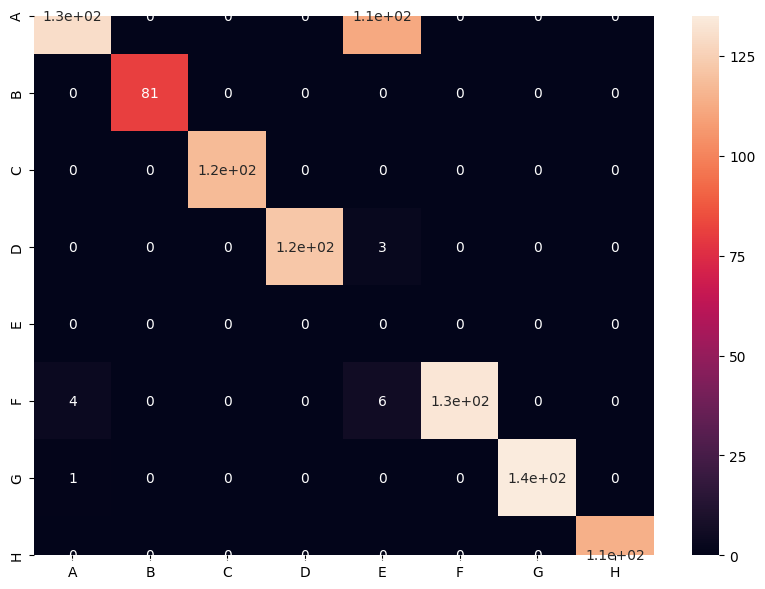

error rate on test set = 26.67823980251948 percent
 
epoch= 9 	 time= 69.20949959754944 s 	 lr= 0.0033333333333333335 	 loss= 1.4940569964902741 	 error= 27.310267170625075 percent
Average Elapsed Time for One Inference
0.010194338858127594
              precision    recall  f1-score   support

           0       0.98      0.55      0.70       242
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00       118
           3       1.00      0.98      0.99       125
           4       0.00      0.00      0.00         0
           5       1.00      0.92      0.96       144
           6       1.00      1.00      1.00       135
           7       1.00      1.00      1.00       114

    accuracy                           0.87       959
   macro avg       0.87      0.81      0.83       959
weighted avg       0.99      0.87      0.92       959



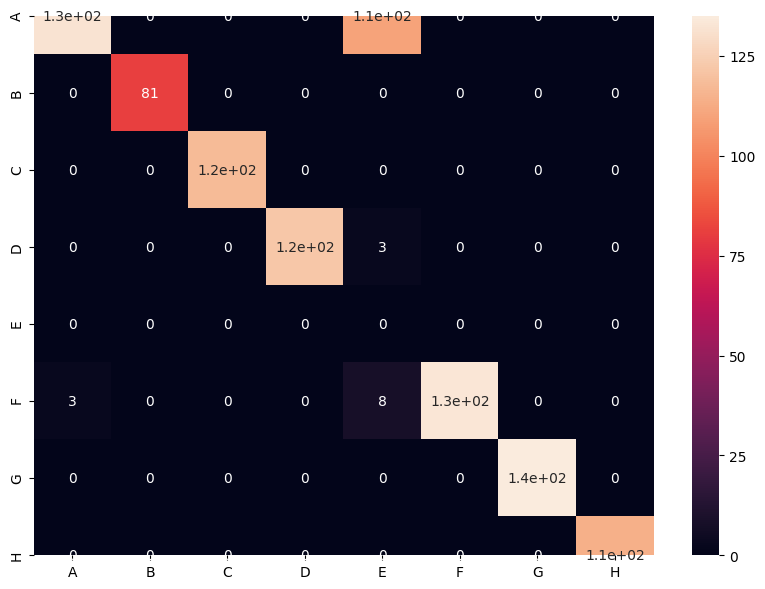

error rate on test set = 26.67823980251948 percent
 


In [0]:
elapsed_training=time.time()

loss_prev = 0

for epoch in range(1,20):
    
    if not epoch%5:
        my_lr = my_lr / 1.5
        
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(train_size)
    
    for count in range(0,train_size,bs):
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+bs]
        minibatch_data_r =  train_data_r[indices].unsqueeze(dim=1)
        minibatch_data_i =  train_data_i[indices].unsqueeze(dim=1)
        minibatch_label=  train_label[:, indices]
        
        minibatch_data_r=minibatch_data_r.to(device, dtype = float)
        minibatch_data_i=minibatch_data_i.to(device, dtype = float)
        minibatch_label=minibatch_label.to(device, dtype = float).squeeze(dim = 0).long()
        
        inputsr = (minibatch_data_r - meanr)/stdr      # ONLY CHANGE IS HERE!
        inputsi = (minibatch_data_i - meani)/stdi      # ONLY CHANGE IS HERE!
        inputsr.requires_grad_()
        inputsi.requires_grad_()

        start=time.time()
        scores=net( [inputsr, inputsi]) 
        
        
        elapsed = (time.time()-start)

        
#         print("ELAPSED")
#         print(elapsed)
#         print("#######")

        loss =  criterion( scores, minibatch_label) 
          
        loss.backward()
        
        optimizer.step()
        
        # COMPUTE STATS
        
        running_loss += loss.detach().item()
        
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        

    training_time = time.time()-elapsed_training

    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    #elapsed = (time.time()-start)/60
    
    if abs(total_loss-loss_prev)<0.0001:
        break
    loss_prev = total_loss
    
    print('epoch=',epoch, '\t time=', training_time,'s', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_uwb_test_set() 
    print(' ')

#### Construct Depthwise Separable Convolution and Dilated Convolution (Mobile Net)

Next, we use a complex-valued CNN network. Traditional CNNs are based on real-valued convolution operations. However, the demodulated signal obtained from the radar complex-valued. If we only feed absolute value or real part or imaginary part of the original signal into the net-work we will lose much valuable information. 

We also make our CNN model aggregate both temporal and frequent information to extract the features from rooms.  

We tried different strategies to make the network lightweight, the strategies include depthwise separable convolution, and dilated convolution. Replacing traditional full convolutional operationwith depthwise convolution and pointwise convolution and group convolution reduce the number of operations requiredby convolution.

In [0]:
dilation_num = 2
mystic_num = 17000

class UWB_MobileNet(nn.Module):

    def __init__(self):
       
        super(UWB_MobileNet, self).__init__()
        
        self.conv1 = ComplexConv2d(1, 50, 3, padding = 1, dilation = dilation_num)
        self.bn1  = ComplexBatchNorm2d(50)
        self.pool1 = ComplexMaxPool2d(2, 2)
        
        
        self.conv2 = ComplexConv2d(50, 50, 3, padding = 1,groups = 50, dilation = dilation_num)
        self.conv2_p = ComplexConv2d(50, 100, 1, padding = 1)
        self.bn2  = ComplexBatchNorm2d(100)
        self.pool2 = ComplexMaxPool2d(2, 2)
        
        self.linear1 = ComplexLinear(mystic_num, num_of_classes)
        #self.linear2 = ComplexLinear(50, num_of_classes)

    def modular_forward(self, x):
        
        xr = x[0].float()
        xi = x[1].float()  #torch.zeros(xr.shape, dtype = xr.dtype, device = xr.device)

        # CL1:   4000 x 30  -->    50 x 28 x 28 
        xr, xi = self.conv1(xr, xi)
        xr, xi = self.bn1(xr, xi)
        xr, xi = complex_relu(xr, xi)
        
        # MP1: 50 x 4000 x 30 -->    50 x 14 x 14
        xr, xi = self.pool1(xr, xi)
        
        # CL2:   50 x 2000 x 15  -->    100 x 2000 x 15
        xr, xi = self.conv2(xr, xi)
        xr, xi = self.conv2_p(xr, xi)
        xr, xi = self.bn2(xr, xi)
        xr, xi = complex_relu(xr, xi)
        
        # MP2: 100 x 2000 x 15 -->    100 x 1000 x 7
        xr, xi = self.pool2(xr, xi)

        # LL1:   100 x 1000 x 7 = 4900  -->  100 
        xr = xr.view(-1, mystic_num)
        xi = xi.view(-1, mystic_num)
        xr, xi = self.linear1(xr, xi)
        xr, xi = complex_relu(xr, xi)

        x = torch.sqrt(torch.pow(xr,2)+torch.pow(xi,2))
        return x
    
    def forward(self, x):
        
        x = self.modular_forward(x)
        
        return F.softmax(x, dim=1)
       # return x

#### Count the parameter number on Mobile Net: 0.28 million (~39% reduction)

In [0]:
net=UWB_MobileNet()

net = net.to(device)

print(net)
utils.display_num_param(net)

meanr=meanr.to(device)
stdr=stdr.to(device)

meani=meani.to(device)
stdi=stdi.to(device)

UWB_MobileNet(
  (conv1): ComplexConv2d(
    (conv_r): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
    (conv_i): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
  )
  (bn1): ComplexBatchNorm2d()
  (pool1): ComplexMaxPool2d()
  (conv2): ComplexConv2d(
    (conv_r): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2), groups=50)
    (conv_i): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2), groups=50)
  )
  (conv2_p): ComplexConv2d(
    (conv_r): Conv2d(50, 100, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (conv_i): Conv2d(50, 100, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (bn2): ComplexBatchNorm2d()
  (pool2): ComplexMaxPool2d()
  (linear1): ComplexLinear(
    (fc_r): Linear(in_features=17000, out_features=8, bias=True)
    (fc_i): Linear(in_features=17000, out_features=8, bias=True)
  )
)
There are 284966 (0.28 million) paramet

#### evaluation on Mobile Net with UWB data

epoch= 1 	 time= 6.046992778778076 s 	 lr= 0.00019509221155311694 	 loss= 1.4017908812633582 	 error= 13.13615914966379 percent
Average Elapsed Time for One Inference
0.009848264356454214
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       135
           1       1.00      0.84      0.92        96
           2       1.00      0.93      0.96       127
           3       1.00      0.82      0.90       149
           4       1.00      0.80      0.89       152
           5       1.00      0.81      0.90       164
           6       1.00      0.99      1.00       136
           7       0.00      0.00      0.00         0

    accuracy                           0.88       959
   macro avg       0.88      0.77      0.82       959
weighted avg       1.00      0.88      0.93       959



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


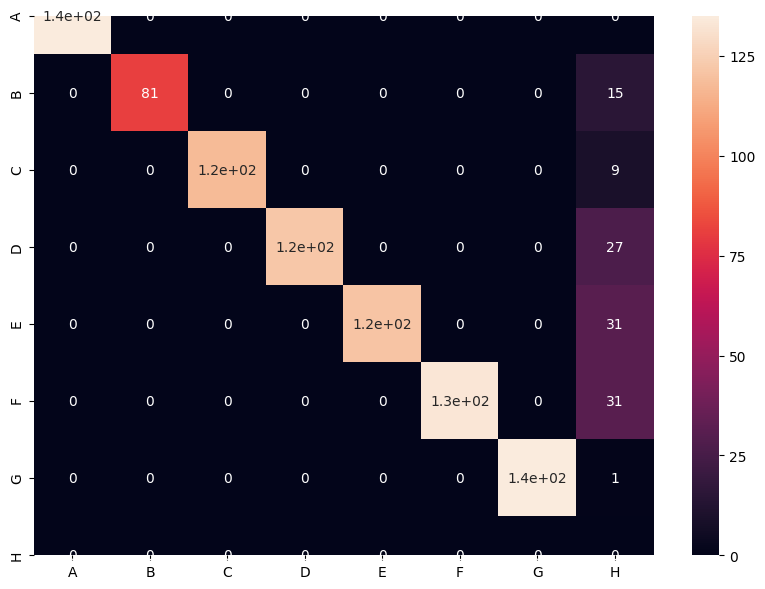

error rate on test set = 11.909720674157143 percent
 
epoch= 2 	 time= 13.558295965194702 s 	 lr= 0.00019509221155311694 	 loss= 1.4007307876433646 	 error= 13.136159202882222 percent
Average Elapsed Time for One Inference
0.009829796850681305
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       135
           1       1.00      0.83      0.91        98
           2       1.00      0.91      0.95       130
           3       1.00      0.84      0.91       145
           4       1.00      0.80      0.89       152
           5       1.00      0.82      0.90       162
           6       1.00      0.99      0.99       137
           7       0.00      0.00      0.00         0

    accuracy                           0.88       959
   macro avg       0.88      0.77      0.82       959
weighted avg       1.00      0.88      0.94       959



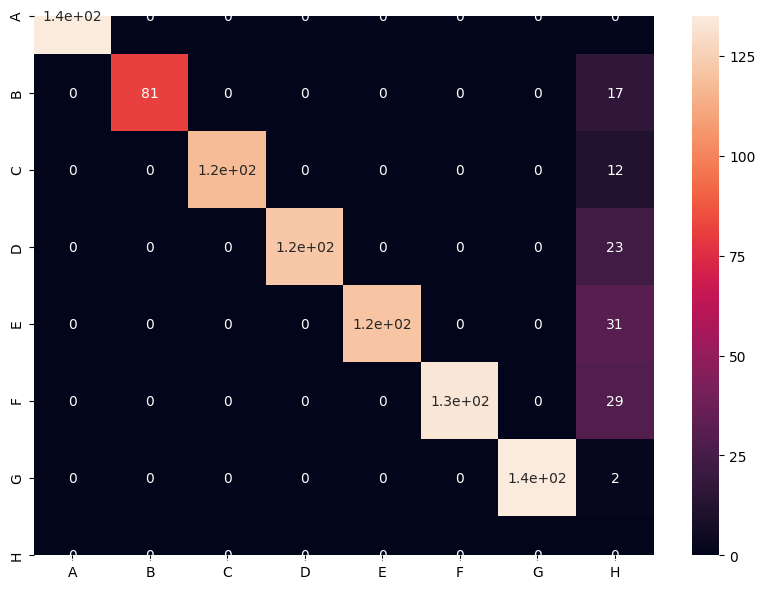

error rate on test set = 11.909720674157143 percent
 
epoch= 3 	 time= 21.04188895225525 s 	 lr= 0.00019509221155311694 	 loss= 1.3989695778914861 	 error= 13.12499852584941 percent
Average Elapsed Time for One Inference
0.01003724088271459
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       135
           1       1.00      0.83      0.91        98
           2       1.00      0.94      0.97       125
           3       1.00      0.79      0.88       155
           4       1.00      0.81      0.89       150
           5       1.00      0.84      0.91       159
           6       1.00      0.99      0.99       137
           7       0.00      0.00      0.00         0

    accuracy                           0.88       959
   macro avg       0.88      0.77      0.82       959
weighted avg       1.00      0.88      0.93       959



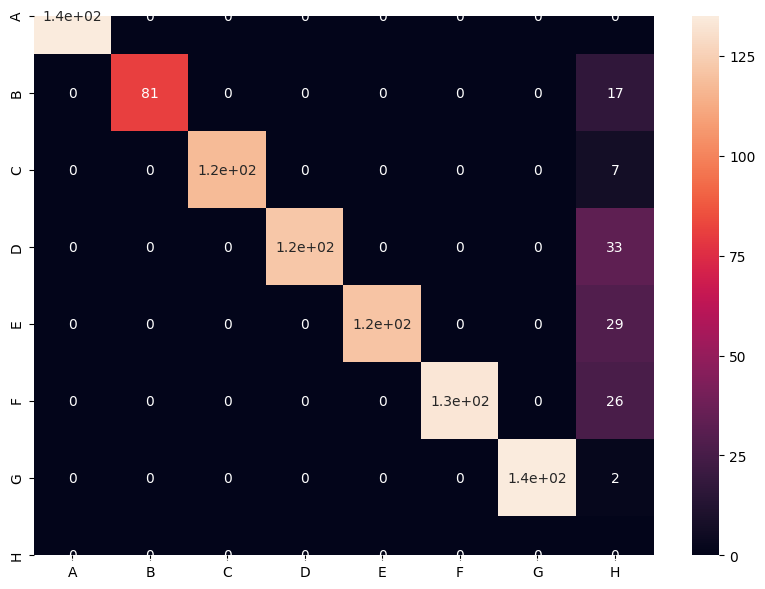

error rate on test set = 11.909720674157143 percent
 
epoch= 4 	 time= 28.592320442199707 s 	 lr= 0.00019509221155311694 	 loss= 1.3925758344786507 	 error= 12.901783947433746 percent
Average Elapsed Time for One Inference
0.009945407509803772
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       138
           1       1.00      0.85      0.92        95
           2       1.00      0.94      0.97       126
           3       1.00      0.81      0.90       150
           4       1.00      0.85      0.92       143
           5       1.00      0.80      0.89       166
           6       1.00      0.96      0.98       141
           7       0.00      0.00      0.00         0

    accuracy                           0.88       959
   macro avg       0.88      0.77      0.82       959
weighted avg       1.00      0.88      0.94       959



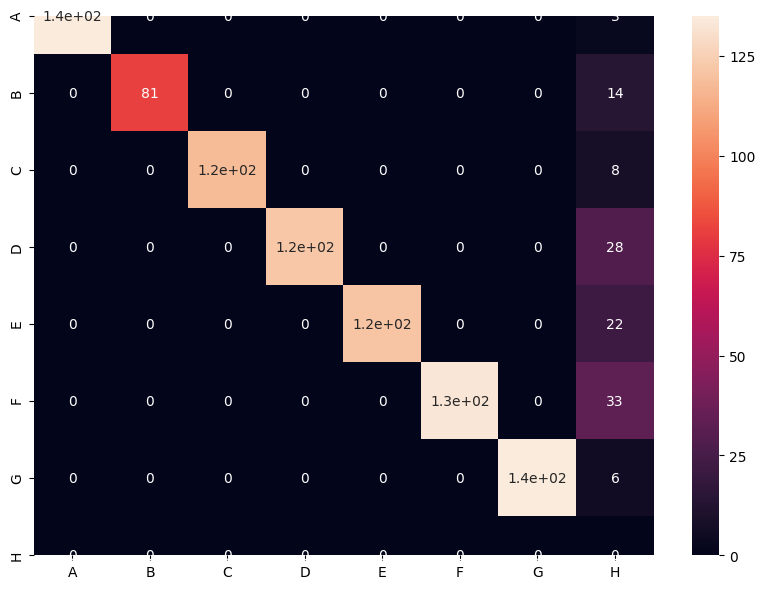

error rate on test set = 11.585646619399387 percent
 
epoch= 5 	 time= 36.33552575111389 s 	 lr= 0.00013006147436874462 	 loss= 1.3882951033966882 	 error= 11.741069677684989 percent
Average Elapsed Time for One Inference
0.009882991512616476
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       151
           1       1.00      0.87      0.93        93
           2       1.00      0.96      0.98       123
           3       1.00      0.85      0.92       144
           4       1.00      0.83      0.91       146
           5       1.00      0.83      0.91       160
           6       1.00      0.95      0.97       142
           7       0.00      0.00      0.00         0

    accuracy                           0.88       959
   macro avg       0.88      0.77      0.82       959
weighted avg       1.00      0.88      0.94       959



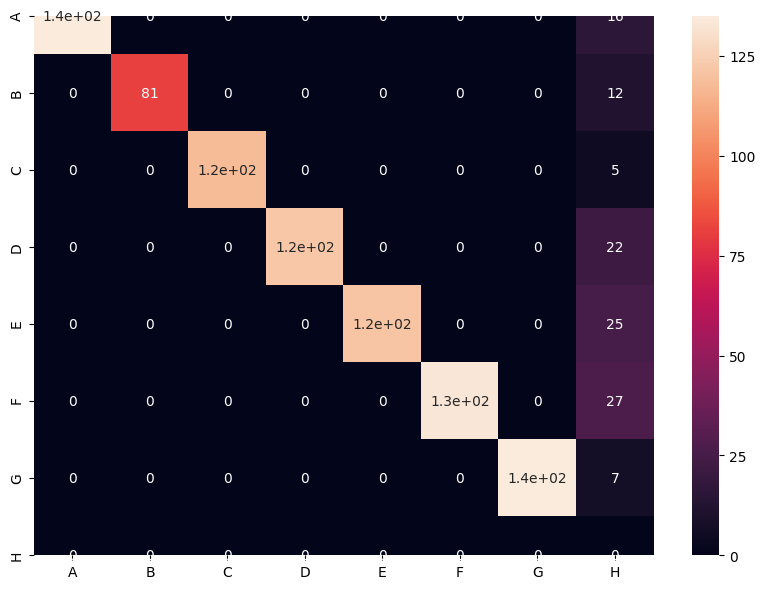

error rate on test set = 10.231480064491432 percent
 
epoch= 6 	 time= 43.84184002876282 s 	 lr= 0.00013006147436874462 	 loss= 1.3868734341646944 	 error= 10.84821264126471 percent
Average Elapsed Time for One Inference
0.010018577178319296
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       162
           1       1.00      0.85      0.92        95
           2       1.00      0.96      0.98       123
           3       1.00      0.88      0.93       139
           4       1.00      0.85      0.92       142
           5       1.00      0.86      0.92       155
           6       1.00      0.94      0.97       143
           7       0.00      0.00      0.00         0

    accuracy                           0.88       959
   macro avg       0.88      0.77      0.82       959
weighted avg       1.00      0.88      0.94       959



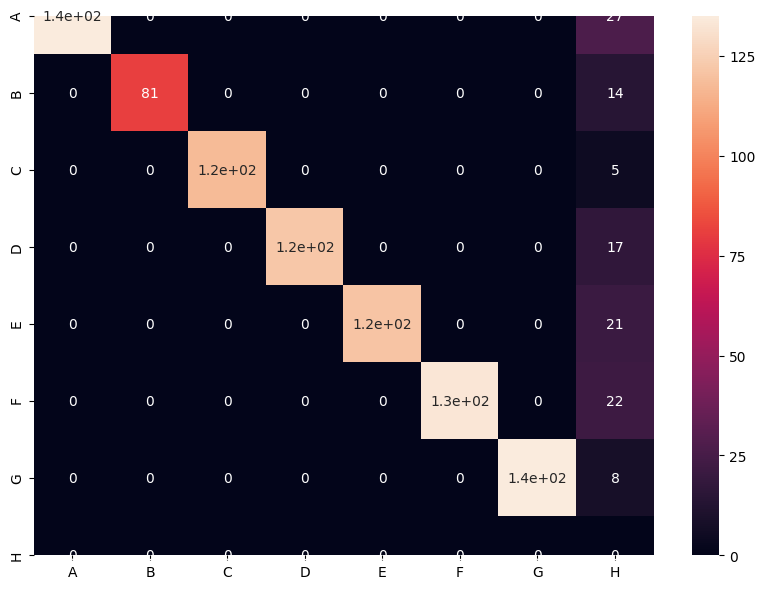

error rate on test set = 9.189813335736591 percent
 


In [0]:
elapsed_training=time.time()
#############################################################
loss_prev = 0
for epoch in range(1,20):
    
    if not epoch%5:
        my_lr = my_lr / 1.5
        
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(train_size)

    for count in range(0,train_size,bs):
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+bs]
        minibatch_data_r =  train_data_r[indices].unsqueeze(dim=1)
        minibatch_data_i =  train_data_i[indices].unsqueeze(dim=1)
        minibatch_label=  train_label[:, indices]
        
        minibatch_data_r=minibatch_data_r.to(device, dtype = float)
        minibatch_data_i=minibatch_data_i.to(device, dtype = float)
        minibatch_label=minibatch_label.to(device, dtype = float).squeeze(dim = 0).long()
        
        inputsr = (minibatch_data_r - meanr)/stdr      # ONLY CHANGE IS HERE!
        inputsi = (minibatch_data_i - meani)/stdi      # ONLY CHANGE IS HERE!
        inputsr.requires_grad_()
        inputsi.requires_grad_()

        start=time.time()
        scores=net( [inputsr, inputsi]) 
        
        
        elapsed = (time.time()-start)

        loss =  criterion( scores, minibatch_label) 
        
          
        loss.backward()
        
        optimizer.step()
        
        # COMPUTE STATS
        
        running_loss += loss.detach().item()
        
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1   
    

    training_time = time.time()-elapsed_training
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    #elapsed = (time.time()-start)/60
    if abs(total_loss-loss_prev)<0.001:
        break
    loss_prev = total_loss
    
    print('epoch=',epoch, '\t time=', training_time,'s', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_uwb_test_set() 
    print(' ')

It can be clearly seen that the improved network is better for resource-constrained devices: (1) the number of parameters in the improved network is less than that in the conventional CNN network (2) once trained, the improved network takes less time to do inference (0.15s vs 0.33s)


## Part 5: Analyzing the results

### *Conclusion*

We achieved room recognition on light weight MobileNet with both Audible Sound and UWB radio.
We first record echo sound and UWB radio response from 8 different rooms, then apply FFT on the raw data to obtain spectrogram which contains both time and frequency inforamtion about the room. Spectrograms from different room distinct with each other, in which we are able to apply Deep neural network to classify them.
We constructed a lightweight MobileNet as well as conventional CNN, evaluation results on Audible and UWB dataset shows that
* Both MobileNet and Conventional CNN are able to achieve room recognition with both Audible sound and UWB radio
* The recognition accuracy with audible sound is ~95% while the accuracy with UWB radio is ~90% on tested network
* MobileNet contains fewer parameters than conventional CNN, our construction achieved 25% and 40% parameter reduction on MobileNet
* MobileNet is able to achieve comparable accuracy with conventional CNN despite it contains fewer parameters
